# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm
import random
import json
import sys
import os
import logging
from dotenv import load_dotenv

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

import optuna

from collections import Counter
from typing import Optional

from sklearn.metrics import mean_absolute_error, mean_squared_error

from bb_energy_prediction import embedder, models, data_utils, train, dataset, evaluate

load_dotenv()

c:\Users\thodo\miniconda3\envs\energy-prediction\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

In [2]:
torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

device(type='cuda', index=1)

# Data

In [3]:
data_df = data_utils.get_data_df(data_path="../energy_data/data.pkl")
if "bb_embeddings" in data_df.columns:
    data_df = data_df.drop(columns="bb_embeddings")

We create the vocab and tokenize the data

In [4]:
vocab = data_utils.get_inst_vocab(data_df)
print(f"size of vocabulary: {len(vocab)}")

size of vocabulary: 3359


We remove outliers in order to have more balanced padded sequences

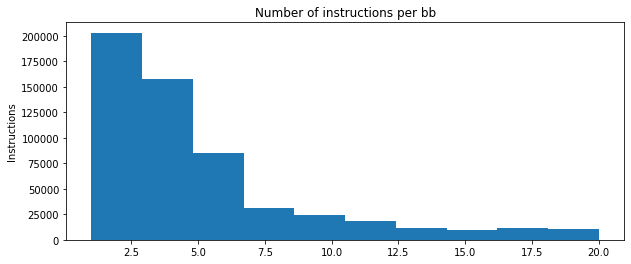

In [5]:
plt.figure(figsize=(10,4))
plt.hist(data_df.bb.map(len))
plt.title("Number of instructions per bb")
plt.ylabel("Instructions")
plt.show()

In [6]:
data_df["encoded_bb"] = data_df.bb.apply(lambda x: data_utils.encode_bb_from_vocab(x, vocab, max_insts=20))
data_df.sample(10)

,bb,energy,program_name,encoded_bb
387074,"[test %r11 %r11, js 0xb40]",0.108170,variable_name_results,"[272, 382]"
510831,"[add $0x30 %r12d, jmp]",0.194707,variable_name_results,"[198, 5]"
119356,"[cmp $0x1 %dl, jnbe 0x3d]",0.267075,find_dyn_sum_results,"[163, 172]"
374220,"[movq %rdi, jmp 0xf]",0.050388,variable_name_results,"[12, 202]"
329386,"[movl %r9d, mov %eax, sub %r9d %eax, cdqe, cmp...",0.382792,time_results,"[23, 109, 123, 50, 55, 135]"
17482,"[movl %edi, mov %rbx %rdx, mov %rbp %rsi, test...",0.108425,declare_results,"[429, 312, 461, 498, 38]"
532669,"[xor %r15d %r15d, jmp]",0.194707,variable_name_results,"[128, 5]"
60133,"[sub %r14 %rbx, mov %rbx %r13, add $0x18 %rsp,...",0.000819,find_biggest_results,"[124, 92, 56, 64, 15, 20, 19, 28, 27, 32, 4]"
198351,"[lea %r14, lea %rbx]",0.033906,ip_results,"[569, 153]"
428360,"[cmp %rax %r12, jb]",0.108170,variable_name_results,"[8, 6]"


Exclude some programs for test purposes, keeping though in the training data the programs with the most data so as not to have a large fraction of the data for testing.

In [7]:
program_names = data_df.program_name.value_counts().index[4:]
test_programs = np.random.choice(program_names, 3, replace=False)
train_val_df = data_df[~data_df.program_name.isin(test_programs)]
test_df = data_df[data_df.program_name.isin(test_programs)]

print(f"Test programs: {test_programs}")
print(f"Test data size: {len(test_df)}")

Test programs: ['faa_results' 'quicksort_results' 'declare_results']
Test data size: 28575


# Optuna Trials

In [8]:
optuna.logging.get_logger("optuna").addHandler(logging.StreamHandler(sys.stdout))
study_name = "lstm-vocab-regression-study-fewer-params"
storage_name = f"sqlite:////Users/thodo/Documents/sxoli/diplomatiki/optuna-studies/lstm-vocab-regression-study.db"
study = optuna.create_study(study_name=study_name, storage=storage_name, load_if_exists=True, direction="minimize")
study.set_user_attr("Loss", "RMSE")
study.set_user_attr("Special vocab tokens", "['unk': 0, 'pad': 1]")
study.set_user_attr("Max instructions", 20)
study.set_user_attr("Training-val data", len(train_val_df))
study.set_user_attr("Testing programs", test_programs.tolist())
study.set_user_attr("lr_decay", 0.6)
study.set_user_attr("lr_decay_step", 9)

[I 2023-02-08 18:33:04,955] A new study created in RDB with name: lstm-vocab-regression-study-fewer-params


A new study created in RDB with name: lstm-vocab-regression-study-fewer-params


In [9]:
def objective(trial):

    embedding_size = trial.suggest_int("embedding_size", 64, 512)
    lstm_layers = trial.suggest_int("lstm_layers", 1, 3)
    hidden_size = trial.suggest_int("hidden_size", 8, 128)
    dense_size = trial.suggest_int("dense_size", 16, 256)
    smaller_dense_size = trial.suggest_int("smaller_dense_size", 8, 64)
    batch_size = trial.suggest_int("batch_size", 256, 1024)
    lstm_dropout = trial.suggest_float("lstm_dropout", 0, 0.2)
    dense_dropout = trial.suggest_float("dense_dropout", 0, 0.15)
    lr = trial.suggest_float("lr", 1e-4, 1e-2)
    #lr_decay = trial.suggest_float("lr_decay", 0.05, 0.8)
    #lr_decay_step = trial.suggest_int("lr_decay_step", 5, 20)

    data_loaders = data_utils.get_data_dict(data_df=train_val_df, enc_type="vocab", batch_size=batch_size)
    train_loader = data_loaders["train_loader"]
    val_loader = data_loaders["val_loader"]

    model = models.LSTM_Regressor(
        vocab_size=len(vocab),
        embedding_size=embedding_size,
        custom_embs=True,
        hidden_size=hidden_size,
        num_layers=lstm_layers,
        dense_size=dense_size,
        smaller_dense_size=smaller_dense_size,
        lstm_dropout=lstm_dropout,
        dense_dropout=dense_dropout,
    )
    train_results = train.train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        lr=lr,
        epochs=200,
        batch_size=batch_size,
        early_stopping=True,
        lr_decay=9,
        lr_decay_step=0.6,
    )

    val_loss = train_results["val_loss"]

    return val_loss[-1]


study.optimize(objective, n_trials=50)

[I 2023-02-08 18:45:55,223] Trial 0 finished with value: 0.5324957979762036 and parameters: {'embedding_size': 511, 'lstm_layers': 3, 'hidden_size': 83, 'dense_size': 76, 'smaller_dense_size': 34, 'batch_size': 482, 'lstm_dropout': 0.04664250330604896, 'dense_dropout': 0.06780855055430586, 'lr': 0.0005377747898590337}. Best is trial 0 with value: 0.5324957979762036.


Trial 0 finished with value: 0.5324957979762036 and parameters: {'embedding_size': 511, 'lstm_layers': 3, 'hidden_size': 83, 'dense_size': 76, 'smaller_dense_size': 34, 'batch_size': 482, 'lstm_dropout': 0.04664250330604896, 'dense_dropout': 0.06780855055430586, 'lr': 0.0005377747898590337}. Best is trial 0 with value: 0.5324957979762036.


[I 2023-02-08 18:51:07,685] Trial 1 finished with value: 0.558505798315073 and parameters: {'embedding_size': 441, 'lstm_layers': 2, 'hidden_size': 51, 'dense_size': 212, 'smaller_dense_size': 64, 'batch_size': 721, 'lstm_dropout': 0.17291088668723287, 'dense_dropout': 0.07303906947154877, 'lr': 0.006542114139423091}. Best is trial 0 with value: 0.5324957979762036.


Trial 1 finished with value: 0.558505798315073 and parameters: {'embedding_size': 441, 'lstm_layers': 2, 'hidden_size': 51, 'dense_size': 212, 'smaller_dense_size': 64, 'batch_size': 721, 'lstm_dropout': 0.17291088668723287, 'dense_dropout': 0.07303906947154877, 'lr': 0.006542114139423091}. Best is trial 0 with value: 0.5324957979762036.


[I 2023-02-08 18:56:12,156] Trial 2 finished with value: 0.5399918099865317 and parameters: {'embedding_size': 246, 'lstm_layers': 1, 'hidden_size': 19, 'dense_size': 175, 'smaller_dense_size': 18, 'batch_size': 575, 'lstm_dropout': 0.0036658971622934634, 'dense_dropout': 0.12935909203749704, 'lr': 0.005121226096137824}. Best is trial 0 with value: 0.5324957979762036.


Trial 2 finished with value: 0.5399918099865317 and parameters: {'embedding_size': 246, 'lstm_layers': 1, 'hidden_size': 19, 'dense_size': 175, 'smaller_dense_size': 18, 'batch_size': 575, 'lstm_dropout': 0.0036658971622934634, 'dense_dropout': 0.12935909203749704, 'lr': 0.005121226096137824}. Best is trial 0 with value: 0.5324957979762036.


[I 2023-02-08 19:02:17,806] Trial 3 finished with value: 0.5400546010836814 and parameters: {'embedding_size': 230, 'lstm_layers': 2, 'hidden_size': 105, 'dense_size': 73, 'smaller_dense_size': 31, 'batch_size': 270, 'lstm_dropout': 0.07143052408245497, 'dense_dropout': 0.14052316981148502, 'lr': 0.00909007295204837}. Best is trial 0 with value: 0.5324957979762036.


Trial 3 finished with value: 0.5400546010836814 and parameters: {'embedding_size': 230, 'lstm_layers': 2, 'hidden_size': 105, 'dense_size': 73, 'smaller_dense_size': 31, 'batch_size': 270, 'lstm_dropout': 0.07143052408245497, 'dense_dropout': 0.14052316981148502, 'lr': 0.00909007295204837}. Best is trial 0 with value: 0.5324957979762036.


[I 2023-02-08 19:09:22,393] Trial 4 finished with value: 0.5522498579128928 and parameters: {'embedding_size': 325, 'lstm_layers': 2, 'hidden_size': 24, 'dense_size': 27, 'smaller_dense_size': 34, 'batch_size': 599, 'lstm_dropout': 0.1968911288350743, 'dense_dropout': 0.026063122787329817, 'lr': 0.009328988924203288}. Best is trial 0 with value: 0.5324957979762036.


Trial 4 finished with value: 0.5522498579128928 and parameters: {'embedding_size': 325, 'lstm_layers': 2, 'hidden_size': 24, 'dense_size': 27, 'smaller_dense_size': 34, 'batch_size': 599, 'lstm_dropout': 0.1968911288350743, 'dense_dropout': 0.026063122787329817, 'lr': 0.009328988924203288}. Best is trial 0 with value: 0.5324957979762036.


[I 2023-02-08 19:30:05,572] Trial 5 finished with value: 0.5464498656513417 and parameters: {'embedding_size': 316, 'lstm_layers': 3, 'hidden_size': 68, 'dense_size': 77, 'smaller_dense_size': 48, 'batch_size': 489, 'lstm_dropout': 0.11412547628635478, 'dense_dropout': 0.12384191235905229, 'lr': 0.0006264182292124428}. Best is trial 0 with value: 0.5324957979762036.


Trial 5 finished with value: 0.5464498656513417 and parameters: {'embedding_size': 316, 'lstm_layers': 3, 'hidden_size': 68, 'dense_size': 77, 'smaller_dense_size': 48, 'batch_size': 489, 'lstm_dropout': 0.11412547628635478, 'dense_dropout': 0.12384191235905229, 'lr': 0.0006264182292124428}. Best is trial 0 with value: 0.5324957979762036.


[I 2023-02-08 19:43:35,227] Trial 6 finished with value: 0.5590117288672406 and parameters: {'embedding_size': 212, 'lstm_layers': 3, 'hidden_size': 66, 'dense_size': 147, 'smaller_dense_size': 44, 'batch_size': 806, 'lstm_dropout': 0.047290770413329124, 'dense_dropout': 0.09593246868792553, 'lr': 0.003260826885115104}. Best is trial 0 with value: 0.5324957979762036.


Trial 6 finished with value: 0.5590117288672406 and parameters: {'embedding_size': 212, 'lstm_layers': 3, 'hidden_size': 66, 'dense_size': 147, 'smaller_dense_size': 44, 'batch_size': 806, 'lstm_dropout': 0.047290770413329124, 'dense_dropout': 0.09593246868792553, 'lr': 0.003260826885115104}. Best is trial 0 with value: 0.5324957979762036.


[I 2023-02-08 19:50:04,619] Trial 7 finished with value: 0.5666667395074603 and parameters: {'embedding_size': 378, 'lstm_layers': 3, 'hidden_size': 77, 'dense_size': 26, 'smaller_dense_size': 28, 'batch_size': 784, 'lstm_dropout': 0.07722717332598512, 'dense_dropout': 0.07514470181409229, 'lr': 0.006101941308344192}. Best is trial 0 with value: 0.5324957979762036.


Trial 7 finished with value: 0.5666667395074603 and parameters: {'embedding_size': 378, 'lstm_layers': 3, 'hidden_size': 77, 'dense_size': 26, 'smaller_dense_size': 28, 'batch_size': 784, 'lstm_dropout': 0.07722717332598512, 'dense_dropout': 0.07514470181409229, 'lr': 0.006101941308344192}. Best is trial 0 with value: 0.5324957979762036.


[I 2023-02-08 19:57:29,662] Trial 8 finished with value: 0.5543203468506153 and parameters: {'embedding_size': 287, 'lstm_layers': 1, 'hidden_size': 20, 'dense_size': 52, 'smaller_dense_size': 20, 'batch_size': 705, 'lstm_dropout': 0.13605575746867857, 'dense_dropout': 0.04283264572986523, 'lr': 0.0038558943095544015}. Best is trial 0 with value: 0.5324957979762036.


Trial 8 finished with value: 0.5543203468506153 and parameters: {'embedding_size': 287, 'lstm_layers': 1, 'hidden_size': 20, 'dense_size': 52, 'smaller_dense_size': 20, 'batch_size': 705, 'lstm_dropout': 0.13605575746867857, 'dense_dropout': 0.04283264572986523, 'lr': 0.0038558943095544015}. Best is trial 0 with value: 0.5324957979762036.


[I 2023-02-08 20:14:15,533] Trial 9 finished with value: 0.5443182425065474 and parameters: {'embedding_size': 78, 'lstm_layers': 3, 'hidden_size': 101, 'dense_size': 56, 'smaller_dense_size': 56, 'batch_size': 315, 'lstm_dropout': 0.09527052260946178, 'dense_dropout': 0.09852950821484695, 'lr': 0.0011217622282847263}. Best is trial 0 with value: 0.5324957979762036.


Trial 9 finished with value: 0.5443182425065474 and parameters: {'embedding_size': 78, 'lstm_layers': 3, 'hidden_size': 101, 'dense_size': 56, 'smaller_dense_size': 56, 'batch_size': 315, 'lstm_dropout': 0.09527052260946178, 'dense_dropout': 0.09852950821484695, 'lr': 0.0011217622282847263}. Best is trial 0 with value: 0.5324957979762036.


[I 2023-02-08 20:27:41,103] Trial 10 finished with value: 0.5392407819076821 and parameters: {'embedding_size': 510, 'lstm_layers': 3, 'hidden_size': 122, 'dense_size': 254, 'smaller_dense_size': 45, 'batch_size': 1019, 'lstm_dropout': 0.022482616533551797, 'dense_dropout': 0.015823962481573618, 'lr': 0.00024164126928227433}. Best is trial 0 with value: 0.5324957979762036.


Trial 10 finished with value: 0.5392407819076821 and parameters: {'embedding_size': 510, 'lstm_layers': 3, 'hidden_size': 122, 'dense_size': 254, 'smaller_dense_size': 45, 'batch_size': 1019, 'lstm_dropout': 0.022482616533551797, 'dense_dropout': 0.015823962481573618, 'lr': 0.00024164126928227433}. Best is trial 0 with value: 0.5324957979762036.


[I 2023-02-08 20:49:29,640] Trial 11 finished with value: 0.5317887925265128 and parameters: {'embedding_size': 512, 'lstm_layers': 3, 'hidden_size': 122, 'dense_size': 235, 'smaller_dense_size': 45, 'batch_size': 961, 'lstm_dropout': 0.02830406823998422, 'dense_dropout': 0.0032673384621072082, 'lr': 0.000513173004792743}. Best is trial 11 with value: 0.5317887925265128.


Trial 11 finished with value: 0.5317887925265128 and parameters: {'embedding_size': 512, 'lstm_layers': 3, 'hidden_size': 122, 'dense_size': 235, 'smaller_dense_size': 45, 'batch_size': 961, 'lstm_dropout': 0.02830406823998422, 'dense_dropout': 0.0032673384621072082, 'lr': 0.000513173004792743}. Best is trial 11 with value: 0.5317887925265128.


[I 2023-02-08 20:57:50,571] Trial 12 finished with value: 0.5451489069245078 and parameters: {'embedding_size': 492, 'lstm_layers': 3, 'hidden_size': 127, 'dense_size': 122, 'smaller_dense_size': 39, 'batch_size': 1010, 'lstm_dropout': 0.040787370922166964, 'dense_dropout': 0.0018163111507448824, 'lr': 0.0019985285576532242}. Best is trial 11 with value: 0.5317887925265128.


Trial 12 finished with value: 0.5451489069245078 and parameters: {'embedding_size': 492, 'lstm_layers': 3, 'hidden_size': 127, 'dense_size': 122, 'smaller_dense_size': 39, 'batch_size': 1010, 'lstm_dropout': 0.040787370922166964, 'dense_dropout': 0.0018163111507448824, 'lr': 0.0019985285576532242}. Best is trial 11 with value: 0.5317887925265128.


[I 2023-02-08 21:16:26,689] Trial 13 finished with value: 0.5198200795074437 and parameters: {'embedding_size': 451, 'lstm_layers': 2, 'hidden_size': 91, 'dense_size': 115, 'smaller_dense_size': 25, 'batch_size': 373, 'lstm_dropout': 0.0002300559967356071, 'dense_dropout': 0.04358939005888012, 'lr': 0.0020263074318056093}. Best is trial 13 with value: 0.5198200795074437.


Trial 13 finished with value: 0.5198200795074437 and parameters: {'embedding_size': 451, 'lstm_layers': 2, 'hidden_size': 91, 'dense_size': 115, 'smaller_dense_size': 25, 'batch_size': 373, 'lstm_dropout': 0.0002300559967356071, 'dense_dropout': 0.04358939005888012, 'lr': 0.0020263074318056093}. Best is trial 13 with value: 0.5198200795074437.


[I 2023-02-08 21:25:19,715] Trial 14 finished with value: 0.5368933111429215 and parameters: {'embedding_size': 412, 'lstm_layers': 2, 'hidden_size': 102, 'dense_size': 119, 'smaller_dense_size': 23, 'batch_size': 923, 'lstm_dropout': 0.007369022742348836, 'dense_dropout': 0.035278008869100645, 'lr': 0.002351976855007478}. Best is trial 13 with value: 0.5198200795074437.


Trial 14 finished with value: 0.5368933111429215 and parameters: {'embedding_size': 412, 'lstm_layers': 2, 'hidden_size': 102, 'dense_size': 119, 'smaller_dense_size': 23, 'batch_size': 923, 'lstm_dropout': 0.007369022742348836, 'dense_dropout': 0.035278008869100645, 'lr': 0.002351976855007478}. Best is trial 13 with value: 0.5198200795074437.


[I 2023-02-08 21:38:08,876] Trial 15 finished with value: 0.5438948952234708 and parameters: {'embedding_size': 446, 'lstm_layers': 1, 'hidden_size': 111, 'dense_size': 183, 'smaller_dense_size': 9, 'batch_size': 428, 'lstm_dropout': 0.001925400368173779, 'dense_dropout': 0.011927706641689725, 'lr': 0.0018399946410039573}. Best is trial 13 with value: 0.5198200795074437.


Trial 15 finished with value: 0.5438948952234708 and parameters: {'embedding_size': 446, 'lstm_layers': 1, 'hidden_size': 111, 'dense_size': 183, 'smaller_dense_size': 9, 'batch_size': 428, 'lstm_dropout': 0.001925400368173779, 'dense_dropout': 0.011927706641689725, 'lr': 0.0018399946410039573}. Best is trial 13 with value: 0.5198200795074437.


[I 2023-02-08 21:45:05,909] Trial 16 finished with value: 0.5704649459748041 and parameters: {'embedding_size': 379, 'lstm_layers': 2, 'hidden_size': 87, 'dense_size': 255, 'smaller_dense_size': 10, 'batch_size': 882, 'lstm_dropout': 0.02914714373853993, 'dense_dropout': 0.0012589104636454049, 'lr': 0.0034789656927865986}. Best is trial 13 with value: 0.5198200795074437.


Trial 16 finished with value: 0.5704649459748041 and parameters: {'embedding_size': 379, 'lstm_layers': 2, 'hidden_size': 87, 'dense_size': 255, 'smaller_dense_size': 10, 'batch_size': 882, 'lstm_dropout': 0.02914714373853993, 'dense_dropout': 0.0012589104636454049, 'lr': 0.0034789656927865986}. Best is trial 13 with value: 0.5198200795074437.


[I 2023-02-08 22:10:20,748] Trial 17 finished with value: 0.5570687705235515 and parameters: {'embedding_size': 122, 'lstm_layers': 2, 'hidden_size': 42, 'dense_size': 221, 'smaller_dense_size': 53, 'batch_size': 398, 'lstm_dropout': 0.06056194278601178, 'dense_dropout': 0.04308627703956686, 'lr': 0.00018643531551188478}. Best is trial 13 with value: 0.5198200795074437.


Trial 17 finished with value: 0.5570687705235515 and parameters: {'embedding_size': 122, 'lstm_layers': 2, 'hidden_size': 42, 'dense_size': 221, 'smaller_dense_size': 53, 'batch_size': 398, 'lstm_dropout': 0.06056194278601178, 'dense_dropout': 0.04308627703956686, 'lr': 0.00018643531551188478}. Best is trial 13 with value: 0.5198200795074437.


[I 2023-02-08 22:25:31,111] Trial 18 finished with value: 0.5423383216063181 and parameters: {'embedding_size': 457, 'lstm_layers': 2, 'hidden_size': 115, 'dense_size': 103, 'smaller_dense_size': 40, 'batch_size': 542, 'lstm_dropout': 0.023218383507417253, 'dense_dropout': 0.025322668880861106, 'lr': 0.0014655679940190174}. Best is trial 13 with value: 0.5198200795074437.


Trial 18 finished with value: 0.5423383216063181 and parameters: {'embedding_size': 457, 'lstm_layers': 2, 'hidden_size': 115, 'dense_size': 103, 'smaller_dense_size': 40, 'batch_size': 542, 'lstm_dropout': 0.023218383507417253, 'dense_dropout': 0.025322668880861106, 'lr': 0.0014655679940190174}. Best is trial 13 with value: 0.5198200795074437.


[I 2023-02-08 22:32:59,475] Trial 19 finished with value: 0.5439919987356806 and parameters: {'embedding_size': 380, 'lstm_layers': 1, 'hidden_size': 95, 'dense_size': 156, 'smaller_dense_size': 26, 'batch_size': 664, 'lstm_dropout': 0.027166813902509388, 'dense_dropout': 0.05280950772070368, 'lr': 0.002503988921440434}. Best is trial 13 with value: 0.5198200795074437.


Trial 19 finished with value: 0.5439919987356806 and parameters: {'embedding_size': 380, 'lstm_layers': 1, 'hidden_size': 95, 'dense_size': 156, 'smaller_dense_size': 26, 'batch_size': 664, 'lstm_dropout': 0.027166813902509388, 'dense_dropout': 0.05280950772070368, 'lr': 0.002503988921440434}. Best is trial 13 with value: 0.5198200795074437.


[I 2023-02-08 22:40:28,372] Trial 20 finished with value: 0.5436173536275563 and parameters: {'embedding_size': 469, 'lstm_layers': 2, 'hidden_size': 92, 'dense_size': 206, 'smaller_dense_size': 14, 'batch_size': 325, 'lstm_dropout': 0.06060538450106985, 'dense_dropout': 0.01985666539843242, 'lr': 0.001497149104153098}. Best is trial 13 with value: 0.5198200795074437.


Trial 20 finished with value: 0.5436173536275563 and parameters: {'embedding_size': 469, 'lstm_layers': 2, 'hidden_size': 92, 'dense_size': 206, 'smaller_dense_size': 14, 'batch_size': 325, 'lstm_dropout': 0.06060538450106985, 'dense_dropout': 0.01985666539843242, 'lr': 0.001497149104153098}. Best is trial 13 with value: 0.5198200795074437.


[I 2023-02-08 23:04:19,739] Trial 21 finished with value: 0.5546619738223123 and parameters: {'embedding_size': 506, 'lstm_layers': 3, 'hidden_size': 81, 'dense_size': 87, 'smaller_dense_size': 34, 'batch_size': 454, 'lstm_dropout': 0.04419617964845857, 'dense_dropout': 0.05402622639278126, 'lr': 0.0008879749957687983}. Best is trial 13 with value: 0.5198200795074437.


Trial 21 finished with value: 0.5546619738223123 and parameters: {'embedding_size': 506, 'lstm_layers': 3, 'hidden_size': 81, 'dense_size': 87, 'smaller_dense_size': 34, 'batch_size': 454, 'lstm_dropout': 0.04419617964845857, 'dense_dropout': 0.05402622639278126, 'lr': 0.0008879749957687983}. Best is trial 13 with value: 0.5198200795074437.


[I 2023-02-08 23:18:34,731] Trial 22 finished with value: 0.5530293963543357 and parameters: {'embedding_size': 414, 'lstm_layers': 3, 'hidden_size': 62, 'dense_size': 103, 'smaller_dense_size': 39, 'batch_size': 379, 'lstm_dropout': 0.015023200128657516, 'dense_dropout': 0.03264200401777407, 'lr': 0.00031282943106101363}. Best is trial 13 with value: 0.5198200795074437.


Trial 22 finished with value: 0.5530293963543357 and parameters: {'embedding_size': 414, 'lstm_layers': 3, 'hidden_size': 62, 'dense_size': 103, 'smaller_dense_size': 39, 'batch_size': 379, 'lstm_dropout': 0.015023200128657516, 'dense_dropout': 0.03264200401777407, 'lr': 0.00031282943106101363}. Best is trial 13 with value: 0.5198200795074437.


[I 2023-02-08 23:29:51,395] Trial 23 finished with value: 0.5504378495471818 and parameters: {'embedding_size': 511, 'lstm_layers': 3, 'hidden_size': 76, 'dense_size': 135, 'smaller_dense_size': 30, 'batch_size': 493, 'lstm_dropout': 0.0006611620293010686, 'dense_dropout': 0.06032142081405169, 'lr': 0.0013034331738025786}. Best is trial 13 with value: 0.5198200795074437.


Trial 23 finished with value: 0.5504378495471818 and parameters: {'embedding_size': 511, 'lstm_layers': 3, 'hidden_size': 76, 'dense_size': 135, 'smaller_dense_size': 30, 'batch_size': 493, 'lstm_dropout': 0.0006611620293010686, 'dense_dropout': 0.06032142081405169, 'lr': 0.0013034331738025786}. Best is trial 13 with value: 0.5198200795074437.


[I 2023-02-08 23:46:48,813] Trial 24 finished with value: 0.548269491050845 and parameters: {'embedding_size': 473, 'lstm_layers': 2, 'hidden_size': 117, 'dense_size': 165, 'smaller_dense_size': 50, 'batch_size': 517, 'lstm_dropout': 0.035930212934208436, 'dense_dropout': 0.011078996198842807, 'lr': 0.002770958874725344}. Best is trial 13 with value: 0.5198200795074437.


Trial 24 finished with value: 0.548269491050845 and parameters: {'embedding_size': 473, 'lstm_layers': 2, 'hidden_size': 117, 'dense_size': 165, 'smaller_dense_size': 50, 'batch_size': 517, 'lstm_dropout': 0.035930212934208436, 'dense_dropout': 0.011078996198842807, 'lr': 0.002770958874725344}. Best is trial 13 with value: 0.5198200795074437.


[I 2023-02-09 00:13:36,180] Trial 25 finished with value: 0.5479088402711428 and parameters: {'embedding_size': 418, 'lstm_layers': 3, 'hidden_size': 87, 'dense_size': 57, 'smaller_dense_size': 58, 'batch_size': 388, 'lstm_dropout': 0.01733735697124668, 'dense_dropout': 0.03883372843247736, 'lr': 0.001031491663448686}. Best is trial 13 with value: 0.5198200795074437.


Trial 25 finished with value: 0.5479088402711428 and parameters: {'embedding_size': 418, 'lstm_layers': 3, 'hidden_size': 87, 'dense_size': 57, 'smaller_dense_size': 58, 'batch_size': 388, 'lstm_dropout': 0.01733735697124668, 'dense_dropout': 0.03883372843247736, 'lr': 0.001031491663448686}. Best is trial 13 with value: 0.5198200795074437.


[I 2023-02-09 00:19:00,390] Trial 26 finished with value: 0.5502568372849668 and parameters: {'embedding_size': 467, 'lstm_layers': 3, 'hidden_size': 48, 'dense_size': 99, 'smaller_dense_size': 24, 'batch_size': 620, 'lstm_dropout': 0.0532742141641762, 'dense_dropout': 0.026265090637052332, 'lr': 0.00218166989131352}. Best is trial 13 with value: 0.5198200795074437.


Trial 26 finished with value: 0.5502568372849668 and parameters: {'embedding_size': 467, 'lstm_layers': 3, 'hidden_size': 48, 'dense_size': 99, 'smaller_dense_size': 24, 'batch_size': 620, 'lstm_dropout': 0.0532742141641762, 'dense_dropout': 0.026265090637052332, 'lr': 0.00218166989131352}. Best is trial 13 with value: 0.5198200795074437.


[I 2023-02-09 00:38:41,920] Trial 27 finished with value: 0.542854502621819 and parameters: {'embedding_size': 353, 'lstm_layers': 2, 'hidden_size': 108, 'dense_size': 131, 'smaller_dense_size': 36, 'batch_size': 327, 'lstm_dropout': 0.03352463415355544, 'dense_dropout': 0.06582326207686492, 'lr': 0.00011248577504379938}. Best is trial 13 with value: 0.5198200795074437.


Trial 27 finished with value: 0.542854502621819 and parameters: {'embedding_size': 353, 'lstm_layers': 2, 'hidden_size': 108, 'dense_size': 131, 'smaller_dense_size': 36, 'batch_size': 327, 'lstm_dropout': 0.03352463415355544, 'dense_dropout': 0.06582326207686492, 'lr': 0.00011248577504379938}. Best is trial 13 with value: 0.5198200795074437.


[I 2023-02-09 00:53:43,907] Trial 28 finished with value: 0.5525175213813782 and parameters: {'embedding_size': 434, 'lstm_layers': 3, 'hidden_size': 128, 'dense_size': 189, 'smaller_dense_size': 44, 'batch_size': 918, 'lstm_dropout': 0.016243710610774773, 'dense_dropout': 0.0479922716347298, 'lr': 0.0009970079861075835}. Best is trial 13 with value: 0.5198200795074437.


Trial 28 finished with value: 0.5525175213813782 and parameters: {'embedding_size': 434, 'lstm_layers': 3, 'hidden_size': 128, 'dense_size': 189, 'smaller_dense_size': 44, 'batch_size': 918, 'lstm_dropout': 0.016243710610774773, 'dense_dropout': 0.0479922716347298, 'lr': 0.0009970079861075835}. Best is trial 13 with value: 0.5198200795074437.


[I 2023-02-09 01:04:40,825] Trial 29 finished with value: 0.5613057450072406 and parameters: {'embedding_size': 484, 'lstm_layers': 1, 'hidden_size': 56, 'dense_size': 232, 'smaller_dense_size': 59, 'batch_size': 759, 'lstm_dropout': 0.041850713136732026, 'dense_dropout': 0.07362990402308985, 'lr': 0.004196975297377854}. Best is trial 13 with value: 0.5198200795074437.


Trial 29 finished with value: 0.5613057450072406 and parameters: {'embedding_size': 484, 'lstm_layers': 1, 'hidden_size': 56, 'dense_size': 232, 'smaller_dense_size': 59, 'batch_size': 759, 'lstm_dropout': 0.041850713136732026, 'dense_dropout': 0.07362990402308985, 'lr': 0.004196975297377854}. Best is trial 13 with value: 0.5198200795074437.


[I 2023-02-09 01:18:58,476] Trial 30 finished with value: 0.5369997418204019 and parameters: {'embedding_size': 432, 'lstm_layers': 2, 'hidden_size': 35, 'dense_size': 44, 'smaller_dense_size': 16, 'batch_size': 259, 'lstm_dropout': 0.032385615095213816, 'dense_dropout': 0.06260131276766694, 'lr': 0.0027425169151964004}. Best is trial 13 with value: 0.5198200795074437.


Trial 30 finished with value: 0.5369997418204019 and parameters: {'embedding_size': 432, 'lstm_layers': 2, 'hidden_size': 35, 'dense_size': 44, 'smaller_dense_size': 16, 'batch_size': 259, 'lstm_dropout': 0.032385615095213816, 'dense_dropout': 0.06260131276766694, 'lr': 0.0027425169151964004}. Best is trial 13 with value: 0.5198200795074437.


[I 2023-02-09 01:31:50,775] Trial 31 finished with value: 0.5492893058364674 and parameters: {'embedding_size': 405, 'lstm_layers': 2, 'hidden_size': 103, 'dense_size': 125, 'smaller_dense_size': 23, 'batch_size': 935, 'lstm_dropout': 0.010750115014615086, 'dense_dropout': 0.03599712070390082, 'lr': 0.001957335193147328}. Best is trial 13 with value: 0.5198200795074437.


Trial 31 finished with value: 0.5492893058364674 and parameters: {'embedding_size': 405, 'lstm_layers': 2, 'hidden_size': 103, 'dense_size': 125, 'smaller_dense_size': 23, 'batch_size': 935, 'lstm_dropout': 0.010750115014615086, 'dense_dropout': 0.03599712070390082, 'lr': 0.001957335193147328}. Best is trial 13 with value: 0.5198200795074437.


[I 2023-02-09 01:46:12,413] Trial 32 finished with value: 0.551009139046073 and parameters: {'embedding_size': 452, 'lstm_layers': 2, 'hidden_size': 98, 'dense_size': 114, 'smaller_dense_size': 21, 'batch_size': 869, 'lstm_dropout': 0.0002067860508568678, 'dense_dropout': 0.0336783855562091, 'lr': 0.0015701172324493157}. Best is trial 13 with value: 0.5198200795074437.


Trial 32 finished with value: 0.551009139046073 and parameters: {'embedding_size': 452, 'lstm_layers': 2, 'hidden_size': 98, 'dense_size': 114, 'smaller_dense_size': 21, 'batch_size': 869, 'lstm_dropout': 0.0002067860508568678, 'dense_dropout': 0.0336783855562091, 'lr': 0.0015701172324493157}. Best is trial 13 with value: 0.5198200795074437.


[I 2023-02-09 01:55:48,997] Trial 33 finished with value: 0.5443837569470991 and parameters: {'embedding_size': 484, 'lstm_layers': 2, 'hidden_size': 117, 'dense_size': 79, 'smaller_dense_size': 29, 'batch_size': 975, 'lstm_dropout': 0.014160815215218716, 'dense_dropout': 0.0435424023647177, 'lr': 0.0007969843783408137}. Best is trial 13 with value: 0.5198200795074437.


Trial 33 finished with value: 0.5443837569470991 and parameters: {'embedding_size': 484, 'lstm_layers': 2, 'hidden_size': 117, 'dense_size': 79, 'smaller_dense_size': 29, 'batch_size': 975, 'lstm_dropout': 0.014160815215218716, 'dense_dropout': 0.0435424023647177, 'lr': 0.0007969843783408137}. Best is trial 13 with value: 0.5198200795074437.


[I 2023-02-09 01:59:42,889] Trial 34 finished with value: 0.5715113086625934 and parameters: {'embedding_size': 174, 'lstm_layers': 2, 'hidden_size': 86, 'dense_size': 94, 'smaller_dense_size': 33, 'batch_size': 861, 'lstm_dropout': 0.00804133290737577, 'dense_dropout': 0.02851834773523255, 'lr': 0.0023980239566465263}. Best is trial 13 with value: 0.5198200795074437.


Trial 34 finished with value: 0.5715113086625934 and parameters: {'embedding_size': 174, 'lstm_layers': 2, 'hidden_size': 86, 'dense_size': 94, 'smaller_dense_size': 33, 'batch_size': 861, 'lstm_dropout': 0.00804133290737577, 'dense_dropout': 0.02851834773523255, 'lr': 0.0023980239566465263}. Best is trial 13 with value: 0.5198200795074437.


[I 2023-02-09 02:12:52,177] Trial 35 finished with value: 0.5417239752012429 and parameters: {'embedding_size': 403, 'lstm_layers': 2, 'hidden_size': 104, 'dense_size': 67, 'smaller_dense_size': 25, 'batch_size': 572, 'lstm_dropout': 0.0259789190538027, 'dense_dropout': 0.02156662681954757, 'lr': 0.0030564881531653983}. Best is trial 13 with value: 0.5198200795074437.


Trial 35 finished with value: 0.5417239752012429 and parameters: {'embedding_size': 403, 'lstm_layers': 2, 'hidden_size': 104, 'dense_size': 67, 'smaller_dense_size': 25, 'batch_size': 572, 'lstm_dropout': 0.0259789190538027, 'dense_dropout': 0.02156662681954757, 'lr': 0.0030564881531653983}. Best is trial 13 with value: 0.5198200795074437.


[I 2023-02-09 02:24:25,503] Trial 36 finished with value: 0.55313880959662 and parameters: {'embedding_size': 333, 'lstm_layers': 3, 'hidden_size': 73, 'dense_size': 111, 'smaller_dense_size': 64, 'batch_size': 671, 'lstm_dropout': 0.010017526756953435, 'dense_dropout': 0.006214377383281122, 'lr': 0.004626621897529648}. Best is trial 13 with value: 0.5198200795074437.


Trial 36 finished with value: 0.55313880959662 and parameters: {'embedding_size': 333, 'lstm_layers': 3, 'hidden_size': 73, 'dense_size': 111, 'smaller_dense_size': 64, 'batch_size': 671, 'lstm_dropout': 0.010017526756953435, 'dense_dropout': 0.006214377383281122, 'lr': 0.004626621897529648}. Best is trial 13 with value: 0.5198200795074437.


[I 2023-02-09 02:28:41,680] Trial 37 finished with value: 0.5502774973413838 and parameters: {'embedding_size': 282, 'lstm_layers': 1, 'hidden_size': 92, 'dense_size': 147, 'smaller_dense_size': 14, 'batch_size': 820, 'lstm_dropout': 0.050029899359095846, 'dense_dropout': 0.01082909559706406, 'lr': 0.002215848849824805}. Best is trial 13 with value: 0.5198200795074437.


Trial 37 finished with value: 0.5502774973413838 and parameters: {'embedding_size': 282, 'lstm_layers': 1, 'hidden_size': 92, 'dense_size': 147, 'smaller_dense_size': 14, 'batch_size': 820, 'lstm_dropout': 0.050029899359095846, 'dense_dropout': 0.01082909559706406, 'lr': 0.002215848849824805}. Best is trial 13 with value: 0.5198200795074437.


[I 2023-02-09 02:40:14,246] Trial 38 finished with value: 0.5312507394949595 and parameters: {'embedding_size': 356, 'lstm_layers': 2, 'hidden_size': 110, 'dense_size': 37, 'smaller_dense_size': 18, 'batch_size': 740, 'lstm_dropout': 0.07224861787825865, 'dense_dropout': 0.017242790392898395, 'lr': 0.0007343517906465502}. Best is trial 13 with value: 0.5198200795074437.


Trial 38 finished with value: 0.5312507394949595 and parameters: {'embedding_size': 356, 'lstm_layers': 2, 'hidden_size': 110, 'dense_size': 37, 'smaller_dense_size': 18, 'batch_size': 740, 'lstm_dropout': 0.07224861787825865, 'dense_dropout': 0.017242790392898395, 'lr': 0.0007343517906465502}. Best is trial 13 with value: 0.5198200795074437.


[I 2023-02-09 02:53:49,989] Trial 39 finished with value: 0.5397731816613829 and parameters: {'embedding_size': 254, 'lstm_layers': 3, 'hidden_size': 113, 'dense_size': 20, 'smaller_dense_size': 17, 'batch_size': 715, 'lstm_dropout': 0.0673296019560298, 'dense_dropout': 0.01818450548965186, 'lr': 0.0005189138330193969}. Best is trial 13 with value: 0.5198200795074437.


Trial 39 finished with value: 0.5397731816613829 and parameters: {'embedding_size': 254, 'lstm_layers': 3, 'hidden_size': 113, 'dense_size': 20, 'smaller_dense_size': 17, 'batch_size': 715, 'lstm_dropout': 0.0673296019560298, 'dense_dropout': 0.01818450548965186, 'lr': 0.0005189138330193969}. Best is trial 13 with value: 0.5198200795074437.


[I 2023-02-09 03:21:28,582] Trial 40 finished with value: 0.5623757579225175 and parameters: {'embedding_size': 304, 'lstm_layers': 3, 'hidden_size': 122, 'dense_size': 40, 'smaller_dense_size': 41, 'batch_size': 587, 'lstm_dropout': 0.08070454897135525, 'dense_dropout': 0.0022333104781436797, 'lr': 0.0007045977657183192}. Best is trial 13 with value: 0.5198200795074437.


Trial 40 finished with value: 0.5623757579225175 and parameters: {'embedding_size': 304, 'lstm_layers': 3, 'hidden_size': 122, 'dense_size': 40, 'smaller_dense_size': 41, 'batch_size': 587, 'lstm_dropout': 0.08070454897135525, 'dense_dropout': 0.0022333104781436797, 'lr': 0.0007045977657183192}. Best is trial 13 with value: 0.5198200795074437.


[I 2023-02-09 03:44:36,473] Trial 41 finished with value: 0.5517182456234754 and parameters: {'embedding_size': 340, 'lstm_layers': 2, 'hidden_size': 106, 'dense_size': 68, 'smaller_dense_size': 26, 'batch_size': 933, 'lstm_dropout': 0.05454018867957181, 'dense_dropout': 0.030041125399107423, 'lr': 0.0016340133669102098}. Best is trial 13 with value: 0.5198200795074437.


Trial 41 finished with value: 0.5517182456234754 and parameters: {'embedding_size': 340, 'lstm_layers': 2, 'hidden_size': 106, 'dense_size': 68, 'smaller_dense_size': 26, 'batch_size': 933, 'lstm_dropout': 0.05454018867957181, 'dense_dropout': 0.030041125399107423, 'lr': 0.0016340133669102098}. Best is trial 13 with value: 0.5198200795074437.


[I 2023-02-09 03:57:05,070] Trial 42 finished with value: 0.5654575361737183 and parameters: {'embedding_size': 363, 'lstm_layers': 2, 'hidden_size': 99, 'dense_size': 35, 'smaller_dense_size': 20, 'batch_size': 977, 'lstm_dropout': 0.040251976234034675, 'dense_dropout': 0.01718064761509794, 'lr': 0.0012330706589279454}. Best is trial 13 with value: 0.5198200795074437.


Trial 42 finished with value: 0.5654575361737183 and parameters: {'embedding_size': 363, 'lstm_layers': 2, 'hidden_size': 99, 'dense_size': 35, 'smaller_dense_size': 20, 'batch_size': 977, 'lstm_dropout': 0.040251976234034675, 'dense_dropout': 0.01718064761509794, 'lr': 0.0012330706589279454}. Best is trial 13 with value: 0.5198200795074437.


[I 2023-02-09 04:08:34,989] Trial 43 finished with value: 0.5467223425706228 and parameters: {'embedding_size': 398, 'lstm_layers': 2, 'hidden_size': 82, 'dense_size': 87, 'smaller_dense_size': 32, 'batch_size': 801, 'lstm_dropout': 0.02345865341395767, 'dense_dropout': 0.03894207766647067, 'lr': 0.0005309611318463784}. Best is trial 13 with value: 0.5198200795074437.


Trial 43 finished with value: 0.5467223425706228 and parameters: {'embedding_size': 398, 'lstm_layers': 2, 'hidden_size': 82, 'dense_size': 87, 'smaller_dense_size': 32, 'batch_size': 801, 'lstm_dropout': 0.02345865341395767, 'dense_dropout': 0.03894207766647067, 'lr': 0.0005309611318463784}. Best is trial 13 with value: 0.5198200795074437.


[I 2023-02-09 04:28:47,657] Trial 44 finished with value: 0.5451349485410403 and parameters: {'embedding_size': 438, 'lstm_layers': 2, 'hidden_size': 123, 'dense_size': 150, 'smaller_dense_size': 21, 'batch_size': 756, 'lstm_dropout': 0.08372073176212984, 'dense_dropout': 0.08252035769154498, 'lr': 0.0018097070971821749}. Best is trial 13 with value: 0.5198200795074437.


Trial 44 finished with value: 0.5451349485410403 and parameters: {'embedding_size': 438, 'lstm_layers': 2, 'hidden_size': 123, 'dense_size': 150, 'smaller_dense_size': 21, 'batch_size': 756, 'lstm_dropout': 0.08372073176212984, 'dense_dropout': 0.08252035769154498, 'lr': 0.0018097070971821749}. Best is trial 13 with value: 0.5198200795074437.


[I 2023-02-09 04:45:40,718] Trial 45 finished with value: 0.5475005130629894 and parameters: {'embedding_size': 492, 'lstm_layers': 2, 'hidden_size': 108, 'dense_size': 120, 'smaller_dense_size': 36, 'batch_size': 458, 'lstm_dropout': 0.006895386004358448, 'dense_dropout': 0.008059483704879529, 'lr': 0.003258171628948555}. Best is trial 13 with value: 0.5198200795074437.


Trial 45 finished with value: 0.5475005130629894 and parameters: {'embedding_size': 492, 'lstm_layers': 2, 'hidden_size': 108, 'dense_size': 120, 'smaller_dense_size': 36, 'batch_size': 458, 'lstm_dropout': 0.006895386004358448, 'dense_dropout': 0.008059483704879529, 'lr': 0.003258171628948555}. Best is trial 13 with value: 0.5198200795074437.


[I 2023-02-09 05:02:18,797] Trial 46 finished with value: 0.5547141396082365 and parameters: {'embedding_size': 449, 'lstm_layers': 2, 'hidden_size': 68, 'dense_size': 169, 'smaller_dense_size': 46, 'batch_size': 847, 'lstm_dropout': 0.0708112515620624, 'dense_dropout': 0.023130943714002886, 'lr': 0.0007224220241812453}. Best is trial 13 with value: 0.5198200795074437.


Trial 46 finished with value: 0.5547141396082365 and parameters: {'embedding_size': 449, 'lstm_layers': 2, 'hidden_size': 68, 'dense_size': 169, 'smaller_dense_size': 46, 'batch_size': 847, 'lstm_dropout': 0.0708112515620624, 'dense_dropout': 0.023130943714002886, 'lr': 0.0007224220241812453}. Best is trial 13 with value: 0.5198200795074437.


[I 2023-02-09 05:26:12,853] Trial 47 finished with value: 0.5495763782595025 and parameters: {'embedding_size': 384, 'lstm_layers': 3, 'hidden_size': 94, 'dense_size': 77, 'smaller_dense_size': 28, 'batch_size': 899, 'lstm_dropout': 0.03140185639001031, 'dense_dropout': 0.01495749129758013, 'lr': 0.00010123972283012685}. Best is trial 13 with value: 0.5198200795074437.


Trial 47 finished with value: 0.5495763782595025 and parameters: {'embedding_size': 384, 'lstm_layers': 3, 'hidden_size': 94, 'dense_size': 77, 'smaller_dense_size': 28, 'batch_size': 899, 'lstm_dropout': 0.03140185639001031, 'dense_dropout': 0.01495749129758013, 'lr': 0.00010123972283012685}. Best is trial 13 with value: 0.5198200795074437.


[I 2023-02-09 05:46:09,661] Trial 48 finished with value: 0.5601263117867631 and parameters: {'embedding_size': 495, 'lstm_layers': 2, 'hidden_size': 112, 'dense_size': 56, 'smaller_dense_size': 11, 'batch_size': 361, 'lstm_dropout': 0.045563833083156695, 'dense_dropout': 0.04840712698166334, 'lr': 0.001345978483062183}. Best is trial 13 with value: 0.5198200795074437.


Trial 48 finished with value: 0.5601263117867631 and parameters: {'embedding_size': 495, 'lstm_layers': 2, 'hidden_size': 112, 'dense_size': 56, 'smaller_dense_size': 11, 'batch_size': 361, 'lstm_dropout': 0.045563833083156695, 'dense_dropout': 0.04840712698166334, 'lr': 0.001345978483062183}. Best is trial 13 with value: 0.5198200795074437.


[I 2023-02-09 05:51:47,317] Trial 49 finished with value: 0.5451114989560226 and parameters: {'embedding_size': 360, 'lstm_layers': 1, 'hidden_size': 121, 'dense_size': 142, 'smaller_dense_size': 18, 'batch_size': 956, 'lstm_dropout': 0.0221756842215072, 'dense_dropout': 0.03142018549698433, 'lr': 0.0019255550528765404}. Best is trial 13 with value: 0.5198200795074437.


Trial 49 finished with value: 0.5451114989560226 and parameters: {'embedding_size': 360, 'lstm_layers': 1, 'hidden_size': 121, 'dense_size': 142, 'smaller_dense_size': 18, 'batch_size': 956, 'lstm_dropout': 0.0221756842215072, 'dense_dropout': 0.03142018549698433, 'lr': 0.0019255550528765404}. Best is trial 13 with value: 0.5198200795074437.


In [10]:
study.trials_dataframe().sort_values(by="value").head(10)

,number,value,datetime_start,datetime_complete,duration,params_batch_size,params_dense_dropout,params_dense_size,params_embedding_size,params_hidden_size,params_lr,params_lstm_dropout,params_lstm_layers,params_smaller_dense_size,state
13,13,0.519820,2023-02-08 20:57:50.575055,2023-02-08 21:16:26.675382,0 days 00:18:36.100327,373,0.043589,115,451,91,0.002026,0.000230,2,25,COMPLETE
38,38,0.531251,2023-02-09 02:28:41.684014,2023-02-09 02:40:14.233214,0 days 00:11:32.549200,740,0.017243,37,356,110,0.000734,0.072249,2,18,COMPLETE
11,11,0.531789,2023-02-08 20:27:41.107518,2023-02-08 20:49:29.626810,0 days 00:21:48.519292,961,0.003267,235,512,122,0.000513,0.028304,3,45,COMPLETE
0,0,0.532496,2023-02-08 18:33:05.053001,2023-02-08 18:45:55.203626,0 days 00:12:50.150625,482,0.067809,76,511,83,0.000538,0.046643,3,34,COMPLETE
14,14,0.536893,2023-02-08 21:16:26.692992,2023-02-08 21:25:19.696003,0 days 00:08:53.003011,923,0.035278,119,412,102,0.002352,0.007369,2,23,COMPLETE
30,30,0.537000,2023-02-09 01:04:40.829322,2023-02-09 01:18:58.462220,0 days 00:14:17.632898,259,0.062601,44,432,35,0.002743,0.032386,2,16,COMPLETE
10,10,0.539241,2023-02-08 20:14:15.537230,2023-02-08 20:27:41.090027,0 days 00:13:25.552797,1019,0.015824,254,510,122,0.000242,0.022483,3,45,COMPLETE
39,39,0.539773,2023-02-09 02:40:14.250214,2023-02-09 02:53:49.975782,0 days 00:13:35.725568,715,0.018185,20,254,113,0.000519,0.067330,3,17,COMPLETE
2,2,0.539992,2023-02-08 18:51:07.688029,2023-02-08 18:56:12.142751,0 days 00:05:04.454722,575,0.129359,175,246,19,0.005121,0.003666,1,18,COMPLETE
3,3,0.540055,2023-02-08 18:56:12.160226,2023-02-08 19:02:17.793454,0 days 00:06:05.633228,270,0.140523,73,230,105,0.009090,0.071431,2,31,COMPLETE


In [11]:
print(f"Best lstm-regressor-model params: {study.best_params}, achieving val RMSE: {study.best_value}")

Best lstm-regressor-model params: {'batch_size': 373, 'dense_dropout': 0.04358939005888012, 'dense_size': 115, 'embedding_size': 451, 'hidden_size': 91, 'lr': 0.0020263074318056093, 'lstm_dropout': 0.0002300559967356071, 'lstm_layers': 2, 'smaller_dense_size': 25}, achieving val RMSE: 0.5198200795074437


# Model Training

In [8]:
batch_size = 256

model_params = {
    "embedding_size": 451,
    "hidden_size": 91,
    "num_layers": 2,
    "dense_size": 115,
    "smaller_dense_size": 25,
    "lstm_dropout": 0.0002,
    "dense_dropout": 0.04,
}

train_params = {
    "lr": 0.002,
    "epochs": 50,
    "batch_size": batch_size,
    "verbose": True,
    "early_stopping": True,
}

In [9]:
load = False
save = True

exp_dir = "/Users/thodo/Documents/sxoli/diplomatiki/basic-block-energy-prediction/model_checkpoints/lstm_vocab_models"

data_loaders = data_utils.get_data_dict(
    data_df=train_val_df, batch_size=batch_size, enc_type="vocab"
)
train_loader = data_loaders["train_loader"]
val_loader = data_loaders["val_loader"]

model = models.LSTM_Regressor(vocab_size=len(vocab), custom_embs=True, **model_params)

if load:
    model.load_state_dict(torch.load(f"{exp_dir}/model_final_data/model"))
    model.cuda()
else:
    train_results = train.train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        **train_params,
    )
    if save:
        torch.save(model.state_dict(), f"{exp_dir}/base_model/model")
        additional_attributes = {
            "model_params": model_params,
            "train_params": train_params,
            "loss": "RMSE",
            "number of data": len(train_loader)*batch_size,
            "test programs": test_programs.tolist(),
            "train_loss": train_results["train_loss"],
            "val_loss": train_results["val_loss"],
        }
        with open(f"{exp_dir}/base_model/additional_attributes.json", "w") as file:
            json.dump(additional_attributes, file, indent=4)

Epoch: 1/50, RMSE Train Loss: 0.57725, RMSE Val Loss: 0.57652
Epoch: 2/50, RMSE Train Loss: 0.56757, RMSE Val Loss: 0.57301
Epoch: 3/50, RMSE Train Loss: 0.56328, RMSE Val Loss: 0.57001
Epoch: 4/50, RMSE Train Loss: 0.5612, RMSE Val Loss: 0.56824
Epoch: 5/50, RMSE Train Loss: 0.55976, RMSE Val Loss: 0.56772
Epoch: 6/50, RMSE Train Loss: 0.55842, RMSE Val Loss: 0.56807
Epoch: 7/50, RMSE Train Loss: 0.55811, RMSE Val Loss: 0.56757
Epoch: 8/50, RMSE Train Loss: 0.5595, RMSE Val Loss: 0.5669
Epoch: 9/50, RMSE Train Loss: 0.5569, RMSE Val Loss: 0.56673
Epoch: 10/50, RMSE Train Loss: 0.55459, RMSE Val Loss: 0.56457
Epoch: 11/50, RMSE Train Loss: 0.55424, RMSE Val Loss: 0.56401
Epoch: 12/50, RMSE Train Loss: 0.55371, RMSE Val Loss: 0.56387
Epoch: 13/50, RMSE Train Loss: 0.55339, RMSE Val Loss: 0.56299
Epoch: 14/50, RMSE Train Loss: 0.55325, RMSE Val Loss: 0.56289
Epoch: 15/50, RMSE Train Loss: 0.55306, RMSE Val Loss: 0.56337
Epoch: 16/50, RMSE Train Loss: 0.55295, RMSE Val Loss: 0.56289
Epoch

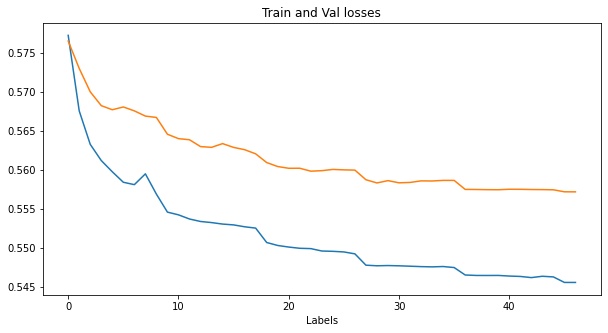

In [10]:
plt.figure(figsize=(10, 5))
plt.plot(train_results["train_loss"], label="train_loss")
plt.plot(train_results["val_loss"], label="val_loss")
plt.title("Train and Val losses")
plt.xlabel("Labels")
plt.legend
plt.show()

# Evaluation

In [11]:
pred_dict = evaluate.evaluate(model=model, val_loader=val_loader, batch_size=batch_size)
preds = pred_dict["preds"]
true_energies = pred_dict["true_energies"]

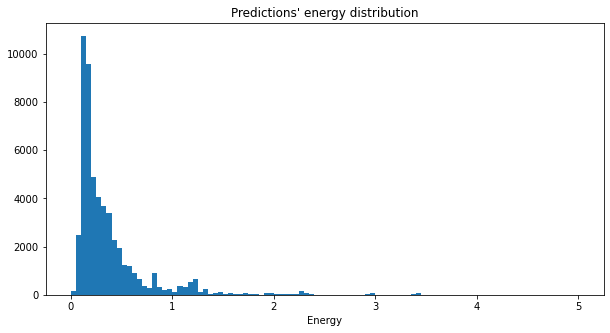

In [12]:
plt.figure(figsize=(10, 5))
plt.hist(preds, bins=100, range=(0,5))
plt.title("Predictions' energy distribution")
plt.xlabel("Energy")
plt.show()

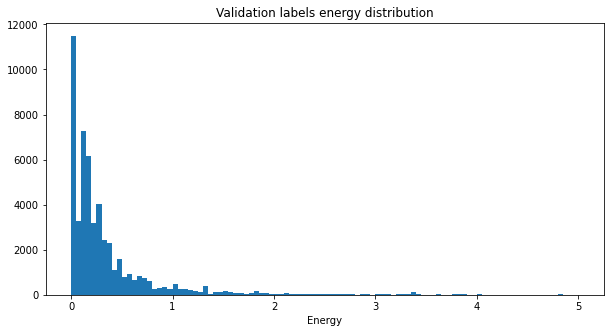

In [13]:
val_labels = true_energies

plt.figure(figsize=(10, 5))
plt.hist(val_labels, bins=100, range=(0,5))
plt.title("Validation labels energy distribution")
plt.xlabel("Energy")
plt.show()

In [14]:
median = np.median(true_energies)
std = np.std(true_energies)
mse = round(mean_squared_error(true_energies, preds), 3)
mae = round(mean_absolute_error(true_energies, preds), 3)

print(f"Labels' median: {median}, Labels' std: {std}")
print(f"MSE: {mse}")
print(f"MAE: {mae}")

Labels' median: 0.19216793083562414, Labels' std: 0.706841713558618
MSE: 0.325
MAE: 0.253


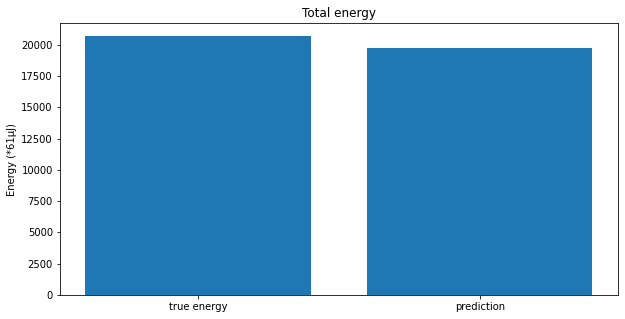

In [15]:
plt.figure(figsize=(10, 5))
plt.title("Total energy")
plt.ylabel("Energy (*61μJ)")
plt.bar(["true energy", "prediction"], [sum(true_energies), sum(preds)])
plt.show()

# Test programs prediction

In [23]:
maes = {}
prog_energy = {}

for test_program in test_programs:
    prog_df = test_df[test_df.program_name == test_program]
    test_preds = evaluate.predict(model=model, test_bbs=prog_df.bb.values, vocab=vocab)
    true_energies = prog_df.energy.values
    
    maes[test_program] = mean_absolute_error(true_energies, test_preds)
    prog_energy[test_program] = {
        "true_energy": sum(true_energies),
        "pred_energy": sum(test_preds),
    }

In [24]:
maes

{'faa_results': 0.5757480644515822,
 'quicksort_results': 0.6340459267943996,
 'declare_results': 0.5003291644799643}